This is an important file!

This is the file where most of my recent work has occurred. I work on producing mock data and then analyzing it by making all sorts of plots.

I have code to make and safe make and save muon-neutrino pdfs (right now I am ignoring electron flavor).

Then there's code to make mock data and find test statistics/best fit hypothesis.

Then lastly I have code to make contour and scatter plots. I have two types of contour plots, one is "classic" and places a contour around the desired confidence interval. Then, my second (and I think more useful plot) is called "heatmap" and places multiple contours as well as displaying a heatmap of confidences. Both these plots could use some fixing up but they're hopefully correct in the information they display.

The scatter plot code may be broken I have not had the chance to thoroughly test it.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
%run neutrino_travel_to_earth_simulation.ipynb
%run new_detections_oom.ipynb
import pickle
from scipy.interpolate import griddata

In [6]:
#creats a pdf of expected lunar neutrinos of muon-flavor detected between 1 and 10 GeVs
#is in terms of log/Gevs
#core_radius input is in km

def make_muon_detections_pdf(core_mantle_density_ratio, core_radius):
    log_energies = np.linspace(0, 0.999, 100)
    detection_rate = []
    for log_energy in log_energies:
        neutrinos_detected_ignoring_oscillation = get_diff_interactions(log_energy) #this is per log GeV
        actual_muons_detected = neutrinos_detected_ignoring_oscillation * monte_carlo_uniform_core(10 ** log_energy, core_mantle_density_ratio, core_radius)[1] # factors in expected flavor ratio
        detection_rate.append(actual_muons_detected)
        
    detections_interp = interp1d(log_energies, detection_rate, kind='linear')
      
        
    #normalizing the pdf    
    total_detections = quad(detections_interp, 0, 0.999, limit=1000)[0]
    def pdf(log_e):
        return detections_interp(log_e) / total_detections 
    
    pdf_interp = interp1d(log_energies, pdf(log_energies), kind='linear') #we have to re-interpolate so that we can save our spline
    
    return pdf_interp


In [7]:
#This is Prof. Hyde's code for making/saving PDFs, repurposed for muon detection pdfs


#import modify_epdfs
#rom modify_epdfs import epdf_new


#######################################
# epdf save/recall code
#######################################

## Import my modified energy pdfs, define function to find and 
## load appropriate pdf, generate and save new one if needed.

# import any previous energy pdf splines I've made.
# If file doesn't exist, create it and populate it with starter pdfs


try:
    with open('muon-pdf-splines-catalog.pkl', 'rb') as f:
        muon_pdf_splines_catalog = pickle.load(f)
except:
    muon_pdf_splines_catalog = dict()
    starter_muon_pdf = make_muon_detections_pdf(1, 330)
    muon_pdf_splines_catalog['core_mantle_density_ratio'] = [1]
    muon_pdf_splines_catalog['core_radius'] = [330]
    muon_pdf_splines_catalog['spline'] = [starter_muon_pdf]
    with open('muon-pdf-splines-catalog.pkl', 'wb') as f:
            pickle.dump(muon_pdf_splines_catalog, f)


In [8]:
#more of prof hyde's code that I repurposed

# Retrieve appropriate muon pdf spline, or if it's not in the
# catalog, evaluate and add it

def muon_pdf_spline(find_core_mantle_density_ratio,find_core_radius):
    index_val = len(muon_pdf_splines_catalog['core_mantle_density_ratio'])
    found = False
    for i in range(0,index_val):
        # round to 4th decimal place - avoid unnecessary replication of splines
        # due to rounding error in late decimal places
        c1 = (np.round(muon_pdf_splines_catalog['core_mantle_density_ratio'][i],2) == np.round(find_core_mantle_density_ratio,2))
        c2 = (np.round(muon_pdf_splines_catalog['core_radius'][i],0) == np.round(find_core_radius,0))
        if c1 and c2:
            found_spline = muon_pdf_splines_catalog['spline'][i]
            found = True
    
    if found == False:
        # generate new spline...
        print(r'Generating new energy pdf spline: core-mantle density ratio =',np.round(find_core_mantle_density_ratio,2),r'core radius =',np.round(find_core_radius,0))
        this_spline = make_muon_detections_pdf(find_core_mantle_density_ratio, find_core_radius)
        # ... and add to catalog...
        muon_pdf_splines_catalog['spline'].append(this_spline)
        muon_pdf_splines_catalog['core_mantle_density_ratio'].append(np.round(find_core_mantle_density_ratio,2))
        muon_pdf_splines_catalog['core_radius'].append(np.round(find_core_radius,0))
        found_spline = this_spline
        # ... and save to file
        with open('muon-pdf-splines-catalog.pkl', 'wb') as f:
            pickle.dump(muon_pdf_splines_catalog, f)
            
    return found_spline

# Wrapper for energy pdf splines: calling this function evaluates
# the signal energy pdf value for each point in sample

def eval_muon_pdf(sample,core_mantle_density_ratio,core_radius):
    muon_pdf = muon_pdf_spline(core_mantle_density_ratio,core_radius)
    muon_pdf_on_sample = muon_pdf(sample)
    return muon_pdf_on_sample


In [9]:
#example of making pdfs

"""new_pdf1 = make_muon_detections_pdf(1, 100)
new_pdf2 = make_muon_detections_pdf(2, 400)
new_pdf3 = make_muon_detections_pdf(10, 500)

log_energies = np.linspace(0, 0.999, 1000)
plt.plot(log_energies, new_pdf1(log_energies), label='ratio = 1, radius=100km')
plt.plot(log_energies, new_pdf2(log_energies), label='ratio = 2, radius=400km')
plt.plot(log_energies, new_pdf3(log_energies), label='ratio = 10, radius=500km')
plt.legend(loc='best')
plt.xlabel('Log Energy (log10 GeV)')
plt.ylabel('Probability')
plt.title('Muon Detection PDF')
plt.title('Muon Detection PDF')
plt.savefig("muon_detection_pdfs_100_energies.png")"""


'new_pdf1 = make_muon_detections_pdf(1, 100)\nnew_pdf2 = make_muon_detections_pdf(2, 400)\nnew_pdf3 = make_muon_detections_pdf(10, 500)\n\nlog_energies = np.linspace(0, 0.999, 1000)\nplt.plot(log_energies, new_pdf1(log_energies), label=\'ratio = 1, radius=100km\')\nplt.plot(log_energies, new_pdf2(log_energies), label=\'ratio = 2, radius=400km\')\nplt.plot(log_energies, new_pdf3(log_energies), label=\'ratio = 10, radius=500km\')\nplt.legend(loc=\'best\')\nplt.xlabel(\'Log Energy (log10 GeV)\')\nplt.ylabel(\'Probability\')\nplt.title(\'Muon Detection PDF\')\nplt.title(\'Muon Detection PDF\')\nplt.savefig("muon_detection_pdfs_100_energies.png")'

In [10]:
#creates mock muon neutrino detection data
#returns a list of log neutrino energies
def make_mock_data(core_mantle_density_ratio, core_radius, num_neutrinos):
    pdf = muon_pdf_spline(core_mantle_density_ratio, core_radius) #make_muon_detections_pdf(core_mantle_density_ratio, core_radius)
    
    log_energies = []
    while len(log_energies) < num_neutrinos:
        random_log_energy = random.uniform(0, 0.999)
        random_probability = random.uniform(0, 3)
    
        if (random_probability < pdf(random_log_energy)):
            log_energies.append(random_log_energy)
    
    return log_energies

In [11]:
#turns mock data into a histogram and plots it
#input is a list of log neutrino energies
def turn_mock_data_into_hist(mock_data):
    num_bins = 100
    log_neutrino_energy_bins = np.linspace(0, 1, num_bins + 1)
    neutrino_energy_histogram = np.zeros(num_bins)
    
    for log_energy in mock_data:
        bin_index = np.digitize(log_energy, log_neutrino_energy_bins) - 1
        if 0 <= bin_index < num_bins:
            neutrino_energy_histogram[bin_index] += 1
            
    bin_centers = (log_neutrino_energy_bins[:-1] + log_neutrino_energy_bins[1:]) / 2

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, neutrino_energy_histogram, width=bin_centers[1] - bin_centers[0], edgecolor='k', alpha=0.7)
    plt.xlabel('Log Neutrino Energy')
    plt.ylabel('Frequency')
    plt.title('Neutrino Energy Histogram')
    plt.grid(True)

In [12]:
#finds log likelihood of data for a given model (density ratio and radius) using muon neutrino pdfs
#data is a list of log neutrino energies
def find_log_likelihood(core_mantle_density_ratio, core_radius, data):
    muon_pdf = muon_pdf_spline(core_mantle_density_ratio, core_radius)
    log_likelihood = 0
    for i in range(len(data)):
        log_likelihood += np.log10(muon_pdf(data[i]))
    
    return log_likelihood

In [13]:
#this function finds the test statistic for a given model (density ratio and radius) and data set
#test statistic is defined as lambda = 2 log([likelihood of test hypothesis] / [likelihood of null hypothesis])
#null hypothesis is radius = 330 km, core-mantle density ratio = 1.77 (core density is thus 6.15 g/cm^2)
#data is a list of log neutrino energies

def find_test_statistic(core_mantle_density_ratio_test_hypothesis, core_radius_test_hypothesis, data):
    test_hypothesis_log_likelihood = find_log_likelihood(core_mantle_density_ratio_test_hypothesis, core_radius_test_hypothesis, data)
    null_hypothesis_log_likelihood = find_log_likelihood(1.77, 330, data)
    
    test_statistic = 2 * (test_hypothesis_log_likelihood - null_hypothesis_log_likelihood)
    return test_statistic

In [14]:
#takes in a list of log detected neutrino energies 
# then returns the best fit density ratio and radius by maximizing test statistic across a range of parameters
#data is a list of log neutrino energies
def find_best_fit_parameters(data):
    core_mantle_density_ratios = np.linspace(0, 30, 10)
    core_radii = np.linspace(0, 500, 10) #in km
    
    first_test = True # whether or not we have tested a pair of parameters yet
    best_fit_test_statistic = 0
    best_fit_density_ratio = 0
    best_fit_radius = 0
    
    for core_mantle_density_ratio in core_mantle_density_ratios:
        for core_radius in core_radii:
            if first_test: #if first set of parameters, they are automatically the best
                best_fit_density_ratio = core_mantle_density_ratio
                best_fit_radius = core_radius
                best_fit_test_statistic = find_test_statistic(core_mantle_density_ratio, core_radius, data)
                first_test = False
            else:
                new_test_statistic = find_test_statistic(core_mantle_density_ratio, core_radius, data)
                if (new_test_statistic > best_fit_test_statistic):
                    best_fit_density_ratio = core_mantle_density_ratio
                    best_fit_radius = core_radius
    
    return best_fit_density_ratio, best_fit_radius, best_fit_test_statistic

In [15]:
#create many null hypothesis mock data sets for find_confidence_interval function
#returns a list of mock data sets of log neutrino energies
def make_mock_data_sets(density_ratio, radius, num_mock_data_sets, neutrinos_per_set):
    data_sets = []
    
    for i in range(num_mock_data_sets):
        data_sets.append(make_mock_data(density_ratio, radius, neutrinos_per_set)) #our null hypothesis is 1.77 density ratio, 330 km core radius
        
    return data_sets

In [16]:
#given a hypothesis's test statistic, finds and returns how significant that result is (the p value)
#i.e. how often would the null hypothesis data set produce such a high test statistic
def find_significance(hypothesis_test_statistic, num_mock_data_sets, neutrinos_per_data_set):    
    null_hypothesis_data_sets = make_mock_data_sets(1.77, 330, num_mock_data_sets, neutrinos_per_data_set)
    
    num_significant_data_sets = 0.0 #this is to keep track of the number of mock data sets with a higher test statistic than our test hypothesis
    
    for data_set in null_hypothesis_data_sets:
        best_fit_test_statistic = find_best_fit_parameters(data_set)[2]
        if best_fit_test_statistic > hypothesis_test_statistic: #does this data set produce a higher test statistic?
            num_significant_data_sets += 1
            
    return num_significant_data_sets / num_mock_data_sets        

In [17]:
#given a test hypothesis ratio and radius, calculates the minimum test statistic to consider for a given confidence interval 

def find_confidence_interval_minimum_test_statistic(percent, test_hypothesis_density_ratio, test_hypothesis_radius, num_mock_data_sets, neutrinos_per_data_set):
    test_hypothesis_data_sets = make_mock_data_sets(test_hypothesis_density_ratio, test_hypothesis_radius, num_mock_data_sets, neutrinos_per_data_set)
    
    best_fit_density_ratios = []
    best_fit_radii = []
    best_fit_test_statistics = []
    
    for data_set in test_hypothesis_data_sets:
        new_density_ratio, new_radius, new_test_statistic = find_best_fit_parameters(data_set) # am i finding test statistic correctly???
        best_fit_density_ratios.append(new_density_ratio)
        best_fit_radii.append(new_radius)
        best_fit_test_statistics.append(new_test_statistic)
    
    minimum_test_statistic = np.percentile(best_fit_test_statistics, 100 - percent)
    
    return minimum_test_statistic

In [18]:
#sets up data for the function make_confidence_interval_contour_plot, so that we can make a contour plot 
#real ratio and real radius are what we imagine are the real ratio and radius of the moon (to see whether we could notice it
# NOT to be used for heatmap_confidence intervals
def make_confidence_interval_data(percent_confidence, real_ratio, real_radius, num_neutrinos):
    real_data = make_mock_data(real_ratio, real_radius, num_neutrinos)
    core_mantle_density_ratios = np.linspace(0, 30, 10)
    core_radii = np.linspace(0, 500, 10) #in km
        
    ratio_radius_test_statistic_tuples = []
    
    for core_mantle_density_ratio in core_mantle_density_ratios:
        for core_radius in core_radii:                
            new_test_statistic = find_test_statistic(core_mantle_density_ratio, core_radius, real_data)
            ratio_radius_test_statistic_tuples.append((core_mantle_density_ratio, core_radius, new_test_statistic))
            
    tuple_ratios, tuple_radii, tuple_test_statistics = zip(*ratio_radius_test_statistic_tuples)
    
    
    best_fit_density_ratio, best_fit_radius, best_fit_test_statistic = find_best_fit_parameters(real_data)
    
    minimum_test_statistic = find_confidence_interval_minimum_test_statistic(percent_confidence,best_fit_density_ratio, best_fit_radius, num_neutrinos, 10)
    
    thirty_percent_conf_minimum_test_statistic = find_confidence_interval_minimum_test_statistic(30, best_fit_density_ratio,
                                                                             best_fit_radius, num_neutrinos, 10) 
    
    sixty_percent_conf_minimum_test_statistic = find_confidence_interval_minimum_test_statistic(60, best_fit_density_ratio,
                                                                             best_fit_radius, num_neutrinos, 10)
    
    ninety_percent_conf_minimum_test_statistic = find_confidence_interval_minimum_test_statistic(90, best_fit_density_ratio,
                                                                             best_fit_radius, num_neutrinos, 10)
    

    
    return tuple_ratios, tuple_radii, tuple_test_statistics, minimum_test_statistic, thirty_percent_conf_minimum_test_statistic, sixty_percent_conf_minimum_test_statistic, ninety_percent_conf_minimum_test_statistic

In [19]:
#sets up data for the function make_heatmap_confidence_interval_contour_plot, so that we can make a contour plot 
#real ratio and real radius are what we imagine are the real ratio and radius of the moon (to see whether we could notice it_
#automatically sets contours at 30 60 and 90 percent confidence
def make_heatmap_confidence_interval_data(real_ratio, real_radius, num_neutrinos):
    real_data = make_mock_data(real_ratio, real_radius, num_neutrinos)
    core_mantle_density_ratios = np.linspace(0, 30, 10)
    core_radii = np.linspace(0, 500, 10) #in km
        
    ratio_radius_test_statistic_tuples = [] #list of tuples with corresponding ratio, radius and test statistic
    
    for core_mantle_density_ratio in core_mantle_density_ratios:
        for core_radius in core_radii:                
            new_test_statistic = find_test_statistic(core_mantle_density_ratio, core_radius, real_data)
            ratio_radius_test_statistic_tuples.append((core_mantle_density_ratio, core_radius, new_test_statistic))
            
    tuple_ratios, tuple_radii, tuple_test_statistics = zip(*ratio_radius_test_statistic_tuples)
    
    
    best_fit_density_ratio, best_fit_radius, best_fit_test_statistic = find_best_fit_parameters(real_data)
        
    thirty_percent_conf_minimum_test_statistic = find_confidence_interval_minimum_test_statistic(30, best_fit_density_ratio,
                                                                             best_fit_radius, num_neutrinos, 10) 
    
    sixty_percent_conf_minimum_test_statistic = find_confidence_interval_minimum_test_statistic(60, best_fit_density_ratio,
                                                                             best_fit_radius, num_neutrinos, 10)
    
    ninety_percent_conf_minimum_test_statistic = find_confidence_interval_minimum_test_statistic(90, best_fit_density_ratio,
                                                                             best_fit_radius, num_neutrinos, 10)
    

    
    return tuple_ratios, tuple_radii, tuple_test_statistics, thirty_percent_conf_minimum_test_statistic, sixty_percent_conf_minimum_test_statistic, ninety_percent_conf_minimum_test_statistic

In [20]:
#this function plots creates a contour plot using the data made by "make_confidence_interval_data"
#ratios, radii, test statistics are lists where the n'th entry give a trio of ratio, radius, and corresponding test statistic
#minimum test statistic is the minimum test statistic for the coordinate to be included in our confidence interval
#percent confidence, real ratio, real radius, and num_neutrinos are just info to be displayed in graph
def make_confidence_interval_contour_plot(ratios, radii, test_statistics, minimum_test_statistic, percent_confidence, real_ratio, real_radius, num_neutrinos):
    
    ratio_points = np.linspace(min(ratios), max(ratios), 100)
    radius_points = np.linspace(min(radii), max(radii), 100)
    ratio_grid, radii_grid = np.meshgrid(ratio_points, radius_points)
    
    test_statistics_grid = griddata((ratios, radii), test_statistics, (ratio_grid, radii_grid), method='linear')

    plt.figure(figsize=(8,6))

    
    contour = plt.contourf(ratio_grid, radii_grid, test_statistics_grid , levels=[-100, minimum_test_statistic, 100], colors=['red', 'blue'], alpha=0.7)

    #make a colorbar
    cbar = plt.colorbar(contour)
    
    # Then set tick labels
    cbar.set_ticks([-30, 30])
    cbar.set_ticklabels([
        r"$\lambda \leq$ " + str(np.round(minimum_test_statistic, 4)),
        r"$\lambda >$ " + str(np.round(minimum_test_statistic, 4))
    ])
    
    #finding best fit parameters
    max_test_statistic_index = test_statistics.index(max(test_statistics))
    best_fit_ratio = ratios[max_test_statistic_index]
    best_fit_radius = radii[max_test_statistic_index]
    
    plt.scatter(best_fit_ratio, best_fit_radius, marker='x', color='black', s=100)
    plt.annotate('Best Fit Value', 
             (best_fit_ratio, best_fit_radius), 
             textcoords="offset points",
             xytext=(10,10),  # offset for text placement
             ha='left',
             fontsize=10,
             arrowprops=dict(arrowstyle='->', color='black'))
    
    
    plt.scatter(real_ratio, real_radius, color='green', s=100, edgecolor='black', label="True Values")
    plt.annotate('\"True\" Value', 
             (real_ratio, real_radius), 
             textcoords="offset points",
             xytext=(10,10),  # offset for text placement
             ha='left',
             fontsize=10,
             arrowprops=dict(arrowstyle='->', color='black'))

    


    # Show the plot
    plt.xlabel(r"$\rho_{core} / \rho_{mantle}$(True = " + str(real_ratio) + ")")
    plt.ylabel(r"$R_{core}$ (km) " + "(True = " + str(real_radius) + ")")
    plt.title(str(percent_confidence)+"% Confidence Interval Plot")
    plt.annotate('num neutrinos = ' + str(num_neutrinos) , xy=(1.05, 1.02), xycoords='axes fraction', ha='center')
    plt.savefig("fixed_confidence_interval_plot_ratio" + str(real_ratio) + "_radius" + str(real_radius) + "_confidence" + str(percent_confidence) + "_neutrinos" + str(num_neutrinos) + ".png")
    plt.close()

In [21]:
#makes a confidence interval plot, but instead creates three contours (at 30, 60 and 90 pct confidence)
#this is overlayed on a heatmat showing the test statistic of each parameter combination
#use the function make_confidence_interval_data() to make the input for this function
def make_heatmap_confidence_interval_plot(ratios, radii, test_statistics, thirty_pct_min_stat, sixty_pct_min_stat, ninety_pct_min_stat, real_ratio, real_radius, num_neutrinos):
    
    #CHANGE FONTSIZE (fontsize=12)
    
    max_test_statistic = max(test_statistics)
    delta_test_statistics = []
    
    for test_statistic in test_statistics:
        delta_test_statistics.append(test_statistic - max_test_statistic)
        
    # Step 1: Create a 2D grid
    ratios = np.array(ratios)
    radii = np.array(radii)
    delta_stats = np.array(delta_test_statistics)
    
    # Get unique sorted values
    unique_ratios = np.unique(ratios)
    unique_radii = np.unique(radii)
    
    # Create a meshgrid
    X, Y = np.meshgrid(unique_ratios, unique_radii)
    
    # Step 2: Reshape stats into a 2D array Z
    Z = np.full(X.shape, np.nan)
    for i in range(len(delta_stats)):
        x_idx = np.where(unique_ratios == ratios[i])[0][0]
        y_idx = np.where(unique_radii == radii[i])[0][0]
        Z[y_idx, x_idx] = delta_stats[i]
    
    # Step 3: Plot heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.pcolormesh(X, Y, Z, shading='auto', cmap='Spectral')
    plt.colorbar(heatmap, label=r'$\Delta_{\lambda}$')
    
    # Step 4: Add contours
    ratio_points = np.linspace(min(ratios), max(ratios), 100)
    radius_points = np.linspace(min(radii), max(radii), 100)
    ratio_grid, radii_grid = np.meshgrid(ratio_points, radius_points)
    
    test_statistics_grid = griddata((ratios, radii), test_statistics, (ratio_grid, radii_grid), method='linear')
    
    linestyles_dict = {
        -100: '--',
        ninety_pct_min_stat: '--',
        sixty_pct_min_stat: '-.',
        thirty_pct_min_stat: ':',
        100: '-'
    }

    
    contours = plt.contour(ratio_grid, radii_grid, test_statistics_grid , levels=[-100, ninety_pct_min_stat, sixty_pct_min_stat, thirty_pct_min_stat, 100], colors=['k','k'],
                     linestyles=["--", "--", "-.", ":", "--"])

    plt.clabel(contours, inline=True, fontsize=8)
    
    
    #finding best fit parameters
    max_test_statistic_index = test_statistics.index(max_test_statistic)
    best_fit_ratio = ratios[max_test_statistic_index]
    best_fit_radius = radii[max_test_statistic_index]
    
    plt.scatter(best_fit_ratio, best_fit_radius, marker='x', color='black', s=100)
    plt.annotate('Best Fit Value', 
             (best_fit_ratio, best_fit_radius), 
             textcoords="offset points",
             xytext=(10,10),  # offset for text placement
             ha='left',
             fontsize=10,
             arrowprops=dict(arrowstyle='->', color='black'))
    
    
    plt.scatter(real_ratio, real_radius, color='black', s=100, edgecolor='black', label="True Values")
    plt.annotate('\"True\" Value', 
             (real_ratio, real_radius), 
             textcoords="offset points",
             xytext=(10,10),  # offset for text placement
             ha='left',
             fontsize=10,
             arrowprops=dict(arrowstyle='->', color='black'))
    
    from matplotlib.lines import Line2D
    
    custom_lines = [
    Line2D([0], [0], color='black', linestyle=':', label='30% confidence'),
    Line2D([0], [0], color='black', linestyle='-.', label='60% confidence'),
    Line2D([0], [0], color='black', linestyle='--', label='90% confidence'),
    ]

    # Add manual legend
    plt.legend(handles=custom_lines, loc='best')
    
    # Final touches
    plt.xlabel(r"$\rho_{core} / \rho_{mantle}$(True = " + str(real_ratio) + ")")
    plt.ylabel(r"$R_{core}$ (km) " + "(True = " + str(real_radius) + ")")
    plt.title("Heatmap Confidence Interval Plot")
    plt.annotate('num neutrinos = ' + str(num_neutrinos) , xy=(1.05, 1.02), xycoords='axes fraction', ha='center')
    plt.savefig("heatmap_confidence_interval_plot_ratio" + str(real_ratio) + "_radius" + str(real_radius) + "_neutrinos" + str(num_neutrinos) + ".png")
    plt.show()

In [22]:
#

In [23]:
#for a supposed "real" ratio and radius, creates many mock data sets.
#then for each of these mock data sets finds the best fit parameters, and plots them
def make_best_fit_scatter_plot(real_ratio, real_radius, num_mock_data_sets, neutrinos_per_data_set):
    mock_data_sets = make_mock_data_sets(real_ratio, real_radius, num_mock_data_sets, neutrinos_per_data_set)
    
    for data_set in mock_data_sets:
        best_fit_ratio, best_fit_radius, best_fit_test_statistic = find_best_fit_parameters(data_set)
        print("scattered ratio:" + str(best_fit_ratio) + " radius: " + str(best_fit_radius))
        plt.scatter(best_fit_ratio, best_fit_radius, marker='x', color='black', s=100)
        
    plt.xlabel(r"$\rho_{core} / \rho_{mantle}$(True = " + str(real_ratio) + ")")
    plt.ylabel(r"$R_{core}$ (km) " + "(True = " + str(real_radius) + ")")
    plt.annotate('num neutrinos = ' + str(neutrinos_per_data_set) , xy=(1.00, 1.02), xycoords='axes fraction', ha='center')
    
    plt.scatter(real_ratio, real_radius, color='black', s=100, edgecolor='black', label="True Values")
    plt.annotate('\"True\" Value', 
             (real_ratio, real_radius), 
             textcoords="offset points",
             xytext=(10,10),  # offset for text placement
             ha='left',
             fontsize=10,
             arrowprops=dict(arrowstyle='->', color='black'))
    
    
    plt.title("Best Fit Scatter Plot")
    
    plt.savefig("best_fit_scatter_plot_ratio" + str(real_ratio) + "_radius" + str(real_radius) + "_neutrinos" + str(neutrinos_per_data_set) + "_sets" + str(num_mock_data_sets) + ".png")
    plt.close()
    

In [24]:
#makes a lot of scatter plots at once
def make_many_scatter_plots():
    ratios = [1, 3, 10]
    radii = [100, 300, 500]
    neutrino_counts = [10, 100, 1000]
    
    for num_neutrinos in neutrino_counts:
        for ratio in ratios:
            for radius in radii:
                plt.clf()
                make_best_fit_scatter_plot(ratio, radius, num_neutrinos, 10)

In [25]:
rats, rads, stats, min_stat, thirty_min_stat, sixty_min_stat, ninety_min_stat = make_confidence_interval_data(30, 2, 400, 10)

Generating new energy pdf spline: core-mantle density ratio = 2 core radius = 400


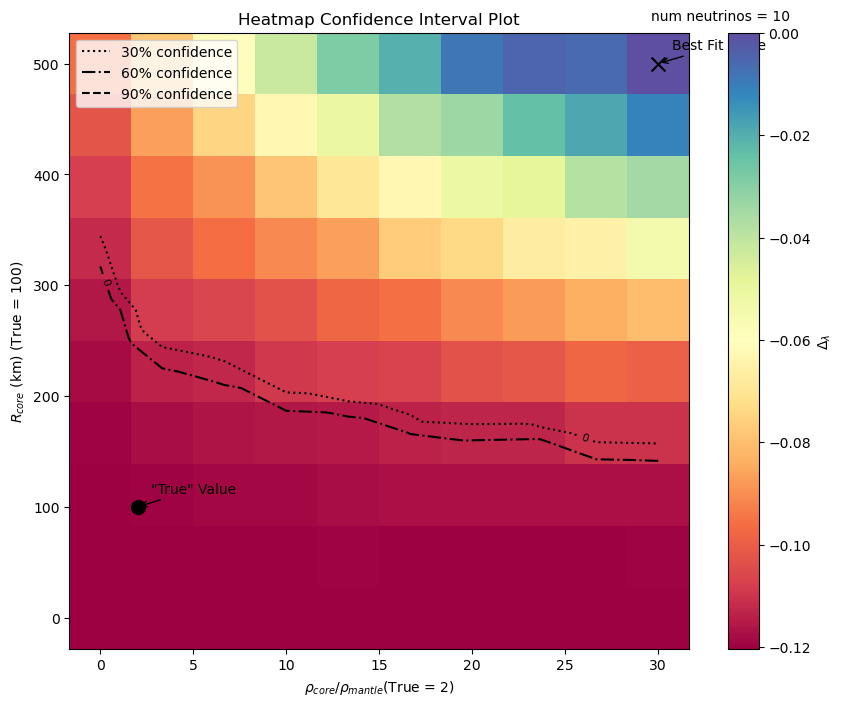

In [26]:
make_heatmap_confidence_interval_plot(rats, rads, stats, thirty_min_stat, sixty_min_stat, ninety_min_stat, 2, 100, 10)

In [27]:
#code to make multiple confidence interval plots at once for a variety of ratios, radii, and amount of neutrinos detected
def make_many_confidence_interval_plots():
    real_ratios = [3, 5, 25, 1]
    real_radii = [3, 100, 400]
    neutrino_counts = [10, 30, 100]
    
    for ratio in real_ratios:
        for radius in real_radii:
            for neutrino_count in neutrino_counts:
                ratios, radii, test_statistics, thirty_percent_min_stat, sixty_percent_min_stat, ninety_percent_min_stat = make_heatmap_confidence_interval_data(ratio, radius, neutrino_count)
                make_heatmap_confidence_interval_plot(ratios, radii, test_statistics, thirty_percent_min_stat, sixty_percent_min_stat, ninety_percent_min_stat, ratio, radius, neutrino_count)